This notebook is a notebook which aims to generate a very generalized N-of-1 trial, and test how it could be extended with adaptivity.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Setup generic n-of-1 parameters

### Supposed to be based on this, but not yet
### Based on "N-of-1 trials in the medical literature: a systematic review"

length = 10
number_of_actions = 2
number_of_patients = 10

In [3]:
import numpy
from adaptive_nof1.models import Model
from adaptive_nof1.basic_types import Outcome

RED_PILL = 1
BLUE_PILL = 2


class PillModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.red_pill_slope = self.rng.normal(0, 1)
        self.patient_id = patient_id

    def generate_context(self, history):
        return {"time_of_the_day": numpy.sin(len(history) / 24 / 3)}

    def observe_outcome(self, action, context):
        if action["treatment"] == RED_PILL:
            return {"enlightment": context["time_of_the_day"] * self.red_pill_slope}
        else:
            return {"enlightment": self.rng.normal(0.3, 1)}

    def __str__(self):
        return f"PillModel"

data_generating_model = lambda patient_id: PillModel(patient_id)

In [4]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import FixedPolicy, FrequentistEpsilonGreedy, ConstantPolicy

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedPolicy(number_of_actions=number_of_actions),
)

adaptive_series_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=ThompsonSampling(
        number_of_actions=number_of_actions, outcome_name="enlightment", epsilon=0.2
    ),
)

constant_1_data = constant_1_runner.simulate(length)
constant_2_data = constant_2_runner.simulate(length)
fixed_schedule_data = fixed_schedule_runner.simulate(length)
adaptive_series_data = adaptive_series_runner.simulate(length)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='t', ylabel='Regret'>

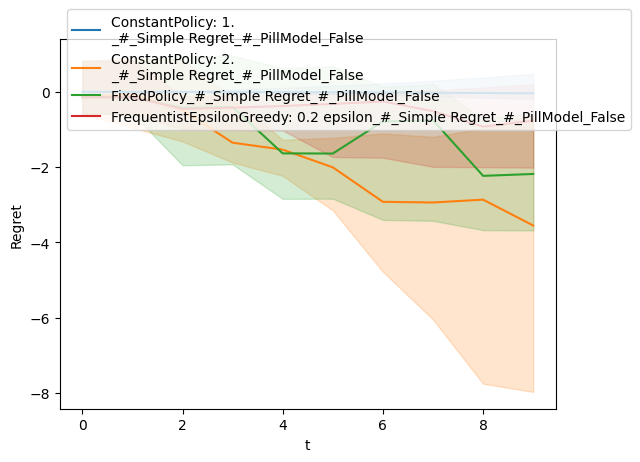

In [6]:
from adaptive_nof1.metrics import SimpleRegret
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

SeriesOfSimulationsData.plot_lines(
    [constant_1_data, constant_2_data, fixed_schedule_data, adaptive_series_data],
    [SimpleRegret(outcome_name="enlightment")],
)

In [7]:
adaptive_series_data.plot_allocations()

:HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)

There are many more policies, metrics, and models to explore. You can find an overview in the respective '\_\_init__.py' files in the folders, which include the different policies.